In [35]:
# Import packages
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import math
import numpy as np


In [36]:
# Setup date and kwargs

class grapeEvents():
    
    def __init__(self):

        self.flare23 = {
            'year': 2023,
            'month': 11,
            'day': 28,
            'filename': 'C:/Users/sabas/Documents/NJIT/Work/wwv/DATA/flare_nov_23/2023-11-28T000000Z_N0000020_G1_FN20vr_FRQ_WWV10.csv',
        }

        self.eclipse24 = {
            'year': 2023,
            'month': 11,
            'day': 28,
            'filename': 'C:/Users/sabas/Documents/NJIT/Work/wwv/DATA/tot_eclipse_24/2024-04-08T000000Z_N0000020_G1_FN20vr_FRQ_WWV10.csv',
        }

evs = grapeEvents()

# date = evs.eclipse24
date = evs.flare23

year = date.get("year")
month = date.get("month")
day = date.get("day")

kwargs = {
    # Grape Parameters
    'mbl' : 5,
    'filename': date.get("filename"),

    # Plot Parameters
    'SPO' : True,
    'val': 'pwr',
    'local': True,
    'axis2': None,
    'end_times': True,
    'save': False,
}


In [37]:
# Modified SunPosOver Code

def neg_time(times):
    for i, time in enumerate(times):
            if time < 0:
                times[i] = time + 24

    return times

def conv_time(timestamp, unit='h'):
    """
    Converts timestamps created for sun position times (hr, min, sec) by sunpy into decimal hours

    :param unit: String hint for what to convert the timestamp to
    :param timestamp: timestamp object containing hr, min, sec
    :return: time in decimal hours
    """

    hr = timestamp.hour
    mi = timestamp.minute
    sec = timestamp.second

    convun = 0
    if unit == 'h':
        convun = hr + mi / 60 + sec / 3600
    if unit == 'm':
        convun = hr * 60 + mi + sec / 60
    if unit == 's':
        convun = hr * 3600 + mi * 60 + sec

    return convun

def round_down(n, decimals=0):
    """
    Rounds the provided number down to the specified number of decimal places

    :param n: the number to be rounded
    :param decimals: the number of decimals the rounded value will contain
    :return: rounded number
    """

    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def sunPosOver(self, ax, fSize: int, end_times: bool = False, local: bool = False, **kwargs):
        """
        Plots overlay of the grape's sunrise, sunset, and solar noon features over the currently open matplotlib plot

        :param fSize: Font size of marker legend text
        :param end_times: Setting for displaying vertical markers for TX or RX
        :param local: Setting for offsetting markers to midpoint local time
        :return: vertical lines on current graph
        """
        sc_factor = kwargs.get('sc_factor', 1)


        loc_offset = self.t_offset if local else 0

        if end_times:
            RXsr = conv_time(self.RXsuntimes['sunrise'])    * sc_factor
            RXsn = conv_time(self.RXsuntimes['solar_noon']) * sc_factor
            RXss = conv_time(self.RXsuntimes['sunset'])     * sc_factor

            RXsrMark = ax.axvline(x=RXsr, color='y', linewidth=3, linestyle='dashed', alpha=0.3)
            RXsnMark = ax.axvline(x=RXsn, color='g', linewidth=3, linestyle='dashed', alpha=0.3)
            RXssMark = ax.axvline(x=RXss, color='b', linewidth=3, linestyle='dashed', alpha=0.3)

            TXsr = conv_time(self.TXsuntimes['sunrise'])    * sc_factor
            TXsn = conv_time(self.TXsuntimes['solar_noon']) * sc_factor
            TXss = conv_time(self.TXsuntimes['sunset'])     * sc_factor

            TXsrMark = ax.axvline(x=TXsr, color='y', linewidth=3, linestyle='dashed', alpha=0.3)
            TXsnMark = ax.axvline(x=TXsn, color='g', linewidth=3, linestyle='dashed', alpha=0.3)
            TXssMark = ax.axvline(x=TXss, color='b', linewidth=3, linestyle='dashed', alpha=0.3)

        Bsr = conv_time(self.Bsuntimes['sunrise'])      * sc_factor
        Bsn = conv_time(self.Bsuntimes['solar_noon'])   * sc_factor
        Bss = conv_time(self.Bsuntimes['sunset'])       * sc_factor

        BsrMark = ax.axvline(x=Bsr, color='y', linewidth=3, linestyle='dashed')
        BsnMark = ax.axvline(x=Bsn, color='g', linewidth=3, linestyle='dashed')
        BssMark = ax.axvline(x=Bss, color='b', linewidth=3, linestyle='dashed')

        times = np.array([Bsr, Bsn, Bss])/sc_factor + loc_offset
        times = neg_time(times)

        utc_string = ' UTC' if not local else ''
        ax.legend([BsrMark, BsnMark, BssMark], ["Sunrise: " + str(round_down(times[0], 2)) + utc_string,
                                                 "Solar Noon: " + str(round_down(times[1], 2)) + utc_string,
                                                 "Sunset: " + str(round_down(times[2], 2)) + utc_string],
                   fontsize=fSize,
                   loc='upper left')


In [38]:
# Get grape for specified date
import grape

g = grape.grapeLoad(year, month, day, **kwargs)

t, f, p = g.getFiltTFPr()


In [39]:
# Select secondary longwave data from correct date
path = 'C:/Users/sabas/Documents/NJIT/Work/wwv/DATA/GOES_flare23.csv'
df = pd.read_csv(path)

d = datetime(2023,11,28)
flaredate = df[pd.to_datetime(df['Universal Time']) >= d]
longwave = flaredate[['Universal Time', 'GOES secondary  Longwave']]
longwave.reset_index(inplace=True)


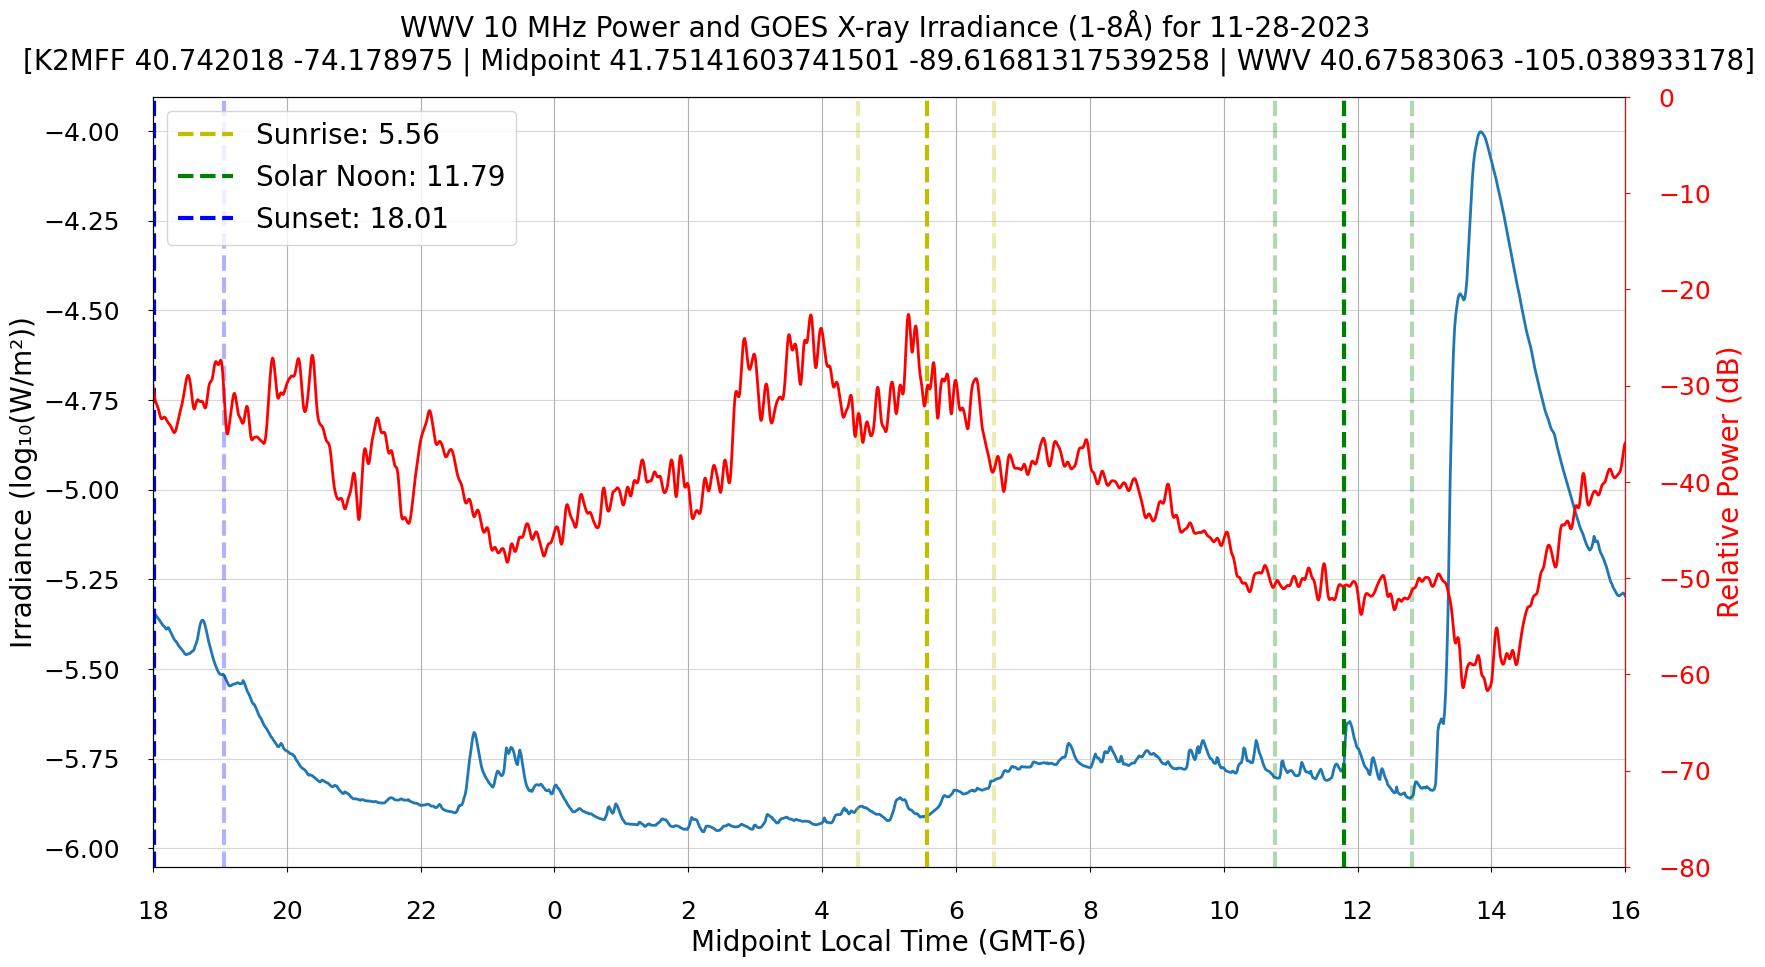

In [40]:
# Plot the data
x = longwave['Universal Time']
y = [math.log10(i) for i in longwave['GOES secondary  Longwave']]

fSize = 20
labelpad = 20
lw = 2

fig = plt.figure(figsize=(19, 10))
ax1 = fig.add_subplot(111)

loc_adj = int(g.t_offset)
pm = '+' if loc_adj > 0 else ''
ax1.plot(x, y, linewidth=lw)
ax1.set_xlabel(f'Midpoint Local Time (GMT{pm}{loc_adj})', fontsize=fSize)
ax1.set_xlim(0, 24)

# Set xticks to show every other label
xticks = ax1.get_xticks()
xticklabels = [x[i].split(' ')[1].split(':')[0] for i in range(len(x))]
xticklabels = [(xt if xt[0] != '0' else xt[1]) for xt in xticklabels]
xticklabels = np.array([(int(xt) + loc_adj) for xt in xticklabels])
xticklabels = neg_time(xticklabels)

# Adjust the labeled time for midpoint locality
nth_sec = 120
ax1.set_xticks(xticks[::nth_sec], 
               labels=xticklabels[::nth_sec] )
ax1.tick_params(axis='x', labelsize=fSize - 2, direction='out', pad=labelpad)
ax1.tick_params(axis='y', labelsize=fSize - 2, direction='out', pad=labelpad)
ax1.grid(axis='x', alpha=1)
ax1.grid(axis='y', alpha=0.5)

# Set ylabel
ax1.set_ylabel('Irradiance (log₁₀(W/m²))', fontsize=fSize)

ax2 = ax1.twinx()

sc_factor = len(x)/24
sunPosOver(g, ax2, fSize, True, True, sc_factor=sc_factor)

t_scaled = [hour*sc_factor for hour in t]
alt_color = 'r'
ax2.plot(t_scaled, p, color=alt_color, linewidth=lw)
ax2.set_ylabel(grape.PLABEL, color=alt_color, fontsize=fSize)
ax2.set_ylim(-80, 0)  # Try these as defaults to keep graphs similar.
ax2.tick_params(axis='y', colors=alt_color, labelsize=fSize - 2, direction='out', pad=labelpad)  # ax1.set_xlim([-2.5, 2.5])  # 0.1Hz Bins (-2.5Hz to +2.5Hz)
ax2.spines['right'].set_color(alt_color)

tstring = f'WWV 10 MHz Power and GOES X-ray Irradiance (1-8Å) for 11-28-2023 \n' \
                            + '[K2MFF %s %s | Midpoint %s %s | WWV %s %s]' \
                            % (g.lat, g.lon, g.blat, g.blon, grape.WWV_LAT, grape.WWV_LON)

ax1.set_title(tstring, pad=labelpad, fontsize=fSize)

plt.savefig('test.png')
plt.show()
